# Feature Engineering - Economiza+ MVP

**Sprint 1 - Dia 3**  
**Objetivo:** Criar 5 features essenciais para clustering

---

## Checklist do Notebook

- [ ] Carregar dados (usuarios, transacoes, estatisticas_mensais)
- [ ] Criar Feature 1: media_renda
- [ ] Criar Feature 2: media_gasto
- [ ] Criar Feature 3: taxa_poupanca
- [ ] Criar Feature 4: pct_gastos_essenciais
- [ ] Criar Feature 5: std_gasto
- [ ] Validar dataset final (500 usuários × 5 features)
- [ ] Salvar features_clustering.csv

---

## Features Essenciais

| # | Feature | Descrição | Motivo |
|---|---------|-----------|--------|
| 1 | **media_renda** | Renda mensal média | Capacidade financeira |
| 2 | **media_gasto** | Gasto total médio | Nível de consumo |
| 3 | **taxa_poupanca** | (renda - gasto) / renda | Comportamento de poupança |
| 4 | **pct_gastos_essenciais** | % gastos em necessidades básicas | Padrão de prioridades |
| 5 | **std_gasto** | Desvio padrão dos gastos | Variabilidade/estabilidade |

---

## ⚠️ CORREÇÃO CRÍTICA APLICADA

**Data da Correção:** 29/01/2026

**Problema Identificado:** A feature `pct_gastos_essenciais` estava sendo calculada incorretamente. O `gasto_essencial` incluía a categoria `Renda` (que é marcada como `is_essencial=True` no dataset), mas `gasto_total` excluía `Renda`. Isso resultava em percentuais > 100% para todos os usuários (média de 184%), que eram clipados para 1.0. Consequentemente, todos os 500 usuários tinham `pct_gastos_essenciais = 1.0`, eliminando a variância desta feature.

**Solução:** A célula 14 foi corrigida para excluir a categoria `Renda` de ambos os cálculos (`gasto_total` e `gasto_essencial`), garantindo que apenas gastos sejam comparados.

**Resultado esperado após correção:**
- Média: ~81.4%
- Desvio padrão: ~3%
- Variação entre usuários: 70-88%

**Impacto:** Após executar este notebook corrigido, será necessário:
1. ✅ Re-executar [03_Clustering.ipynb](03_Clustering.ipynb) para re-treinar o K-means
2. ✅ Re-executar [11_Pipeline_Integrado.ipynb](11_Pipeline_Integrado.ipynb) para salvar novo pipeline
3. ✅ Re-executar [12_Demonstracao.ipynb](12_Demonstracao.ipynb) para validar as correções

---

## 1. Importar Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configurações
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 2)

import warnings
warnings.filterwarnings('ignore')

print("Bibliotecas importadas com sucesso.")
print(f"Pandas: {pd.__version__}")
print(f"NumPy: {np.__version__}")

Bibliotecas importadas com sucesso.
Pandas: 2.3.3
NumPy: 2.4.1


## 2. Carregar Dados

In [2]:
# Carregar os 3 CSVs
# Ajuste o caminho conforme necessário
df_usuarios = pd.read_csv('../data/raw/usuarios.csv')
df_transacoes = pd.read_csv('../data/raw/transacoes.csv')
df_estatisticas = pd.read_csv('../data/raw/estatisticas_mensais.csv')

print("Dados carregados com sucesso.\n")
print(f"Usuários: {df_usuarios.shape}")
print(f"Transações: {df_transacoes.shape}")
print(f"Estatísticas: {df_estatisticas.shape}")

Dados carregados com sucesso.

Usuários: (500, 9)
Transações: (194231, 9)
Estatísticas: (2500, 12)


In [3]:
# Visualizar estrutura dos dados
print("=" * 80)
print("ESTRUTURA DOS DADOS")
print("=" * 80)

print("\nColunas de USUÁRIOS:")
print(df_usuarios.columns.tolist())

print("\nColunas de TRANSAÇÕES:")
print(df_transacoes.columns.tolist())

print("\nColunas de ESTATÍSTICAS:")
print(df_estatisticas.columns.tolist())

ESTRUTURA DOS DADOS

Colunas de USUÁRIOS:
['user_id', 'idade', 'tipo_emprego', 'renda_base', 'variabilidade_renda', 'estado_civil', 'num_dependentes', 'situacao_financeira', 'regiao']

Colunas de TRANSAÇÕES:
['user_id', 'data', 'categoria', 'valor', 'mes', 'ano', 'renda_mes', 'is_essencial', 'is_anomalia']

Colunas de ESTATÍSTICAS:
['user_id', 'ano', 'mes', 'gasto_total', 'gasto_medio', 'gasto_std', 'num_transacoes', 'pct_essencial', 'num_anomalias', 'renda_mes', 'saldo_mes', 'pct_gasto']


## 3. Feature Engineering

### 3.1 Feature 1: media_renda

In [4]:
print("=" * 80)
print("FEATURE 1: MEDIA_RENDA")
print("=" * 80)

# Calcular renda média por usuário
# Usar estatísticas mensais para ter média ao longo do tempo
feature_renda = df_estatisticas.groupby('user_id').agg({
    'renda_mes': 'mean'
}).reset_index()

feature_renda.columns = ['user_id', 'media_renda']

print(f"\nFeature criada com sucesso.")
print(f"   • Shape: {feature_renda.shape}")
print(f"   • Média geral: R${feature_renda['media_renda'].mean():.2f}")
print(f"   • Mediana: R${feature_renda['media_renda'].median():.2f}")
print(f"   • Std: R${feature_renda['media_renda'].std():.2f}")

print("\nPrimeiras linhas:")
display(feature_renda.head(10))

FEATURE 1: MEDIA_RENDA

Feature criada com sucesso.
   • Shape: (500, 2)
   • Média geral: R$3839.18
   • Mediana: R$3454.16
   • Std: R$1728.31

Primeiras linhas:


,user_id,media_renda
0,user_0001,11614.32
1,user_0002,3615.44
2,user_0003,6055.77
3,user_0004,2765.23
4,user_0005,6475.68
5,user_0006,2178.50
6,user_0007,4545.69
7,user_0008,4023.31
8,user_0009,2083.70
9,user_0010,3110.28


### 3.2 Feature 2: media_gasto

In [5]:
print("=" * 80)
print("FEATURE 2: MEDIA_GASTO")
print("=" * 80)

# Calcular gasto médio por usuário
feature_gasto = df_estatisticas.groupby('user_id').agg({
    'gasto_total': 'mean'
}).reset_index()

feature_gasto.columns = ['user_id', 'media_gasto']

print(f"\nFeature criada com sucesso.")
print(f"   • Shape: {feature_gasto.shape}")
print(f"   • Média geral: R${feature_gasto['media_gasto'].mean():.2f}")
print(f"   • Mediana: R${feature_gasto['media_gasto'].median():.2f}")
print(f"   • Std: R${feature_gasto['media_gasto'].std():.2f}")

print("\nPrimeiras linhas:")
display(feature_gasto.head(10))

FEATURE 2: MEDIA_GASTO

Feature criada com sucesso.
   • Shape: (500, 2)
   • Média geral: R$4674.43
   • Mediana: R$4457.10
   • Std: R$1566.11

Primeiras linhas:


,user_id,media_gasto
0,user_0001,3834.97
1,user_0002,7084.61
2,user_0003,3473.66
3,user_0004,3815.74
4,user_0005,6118.83
5,user_0006,2407.15
6,user_0007,3868.95
7,user_0008,6049.14
8,user_0009,2276.06
9,user_0010,4518.16


### 3.3 Feature 3: taxa_poupanca

In [6]:
print("=" * 80)
print("FEATURE 3: TAXA_POUPANCA")
print("=" * 80)

# Mesclar renda e gasto
df_temp = feature_renda.merge(feature_gasto, on='user_id')

# Calcular taxa de poupança: (renda - gasto) / renda
df_temp['taxa_poupanca'] = (df_temp['media_renda'] - df_temp['media_gasto']) / df_temp['media_renda']

# Tratar possíveis divisões por zero (embora improvável com dados sintéticos)
df_temp['taxa_poupanca'] = df_temp['taxa_poupanca'].fillna(0)

# Limitar entre -1 e 1 (casos extremos)
df_temp['taxa_poupanca'] = df_temp['taxa_poupanca'].clip(-1, 1)

feature_poupanca = df_temp[['user_id', 'taxa_poupanca']]

print(f"\nFeature criada com sucesso.")
print(f"   • Shape: {feature_poupanca.shape}")
print(f"   • Média geral: {feature_poupanca['taxa_poupanca'].mean():.3f}")
print(f"   • Mediana: {feature_poupanca['taxa_poupanca'].median():.3f}")
print(f"   • Mínimo: {feature_poupanca['taxa_poupanca'].min():.3f}")
print(f"   • Máximo: {feature_poupanca['taxa_poupanca'].max():.3f}")

# Classificar usuários
endividados = (feature_poupanca['taxa_poupanca'] < 0).sum()
equilibrados = ((feature_poupanca['taxa_poupanca'] >= 0) & 
                (feature_poupanca['taxa_poupanca'] < 0.1)).sum()
poupadores = (feature_poupanca['taxa_poupanca'] >= 0.1).sum()

print(f"\n   • Endividados (< 0): {endividados} ({endividados/len(feature_poupanca)*100:.1f}%)")
print(f"   • Equilibrados (0-10%): {equilibrados} ({equilibrados/len(feature_poupanca)*100:.1f}%)")
print(f"   • Poupadores (>10%): {poupadores} ({poupadores/len(feature_poupanca)*100:.1f}%)")

print("\nPrimeiras linhas:")
display(feature_poupanca.head(10))

FEATURE 3: TAXA_POUPANCA

Feature criada com sucesso.
   • Shape: (500, 2)
   • Média geral: -0.316
   • Mediana: -0.324
   • Mínimo: -1.000
   • Máximo: 0.670

   • Endividados (< 0): 386 (77.2%)
   • Equilibrados (0-10%): 18 (3.6%)
   • Poupadores (>10%): 96 (19.2%)

Primeiras linhas:


,user_id,taxa_poupanca
0,user_0001,0.67
1,user_0002,-0.96
2,user_0003,0.43
3,user_0004,-0.38
4,user_0005,0.06
5,user_0006,-0.10
6,user_0007,0.15
7,user_0008,-0.50
8,user_0009,-0.09
9,user_0010,-0.45


### 3.4 Feature 4: pct_gastos_essenciais

**Correção Aplicada:** Esta feature agora usa corretamente a coluna `is_essencial` que já vem marcada no arquivo de transações, ao invés de tentar definir categorias que não existem no dataset.

In [7]:
print("=" * 80)
print("FEATURE 4: PCT_GASTOS_ESSENCIAIS")
print("=" * 80)

# Usar a coluna 'is_essencial' que já vem marcada no arquivo de transações
# (gerada pelo script de criação do dataset sintético)
print(f"\nUsando coluna 'is_essencial' do arquivo de transações")
print(f"Total de transações: {len(df_transacoes)}")
print(f"Transações essenciais: {df_transacoes['is_essencial'].sum()}")
print(f"Percentual: {df_transacoes['is_essencial'].mean()*100:.1f}%")

# Categorias essenciais (referência - já marcadas no dataset)
categorias_essenciais = [
    'Alimentacao_Casa', 'Habitacao_Aluguel', 'Habitacao_Contas',
    'Transporte', 'Saude', 'Educacao', 
    'Telecomunicacoes', 'Higiene_Limpeza'
]

print(f"\nCategorias consideradas ESSENCIAIS (já marcadas no dataset):")
for cat in categorias_essenciais:
    print(f"   • {cat}")

# CORREÇÃO: Excluir categoria 'Renda' tanto do gasto_total quanto do gasto_essencial
# A Renda está marcada como is_essencial=True no dataset, mas não é um gasto
df_gastos = df_transacoes[df_transacoes['categoria'] != 'Renda']

# Calcular gasto total e gasto essencial por usuário
gasto_total = df_gastos.groupby('user_id')['valor'].sum().reset_index()
gasto_total.columns = ['user_id', 'gasto_total']

gasto_essencial = df_gastos[df_gastos['is_essencial'] == True].groupby('user_id')['valor'].sum().reset_index()
gasto_essencial.columns = ['user_id', 'gasto_essencial']

# Mesclar
feature_essenciais = gasto_total.merge(gasto_essencial, on='user_id', how='left')
feature_essenciais['gasto_essencial'] = feature_essenciais['gasto_essencial'].fillna(0)

# Calcular percentual
feature_essenciais['pct_gastos_essenciais'] = (
    feature_essenciais['gasto_essencial'] / feature_essenciais['gasto_total']
 )

# Tratar divisão por zero
feature_essenciais['pct_gastos_essenciais'] = feature_essenciais['pct_gastos_essenciais'].fillna(0)
feature_essenciais['pct_gastos_essenciais'] = feature_essenciais['pct_gastos_essenciais'].clip(0, 1)

feature_essenciais = feature_essenciais[['user_id', 'pct_gastos_essenciais']]

print(f"\nFeature criada com sucesso.")
print(f"   - Shape: {feature_essenciais.shape}")
print(f"   - Media geral: {feature_essenciais['pct_gastos_essenciais'].mean():.3f} ({feature_essenciais['pct_gastos_essenciais'].mean()*100:.1f}%)")
print(f"   - Mediana: {feature_essenciais['pct_gastos_essenciais'].median():.3f} ({feature_essenciais['pct_gastos_essenciais'].median()*100:.1f}%)")
print(f"   - Minimo: {feature_essenciais['pct_gastos_essenciais'].min():.3f}")
print(f"   - Maximo: {feature_essenciais['pct_gastos_essenciais'].max():.3f}")

print("\nPrimeiras linhas:")
display(feature_essenciais.head(10))

FEATURE 4: PCT_GASTOS_ESSENCIAIS

Usando coluna 'is_essencial' do arquivo de transações
Total de transações: 194231
Transações essenciais: 164251
Percentual: 84.6%

Categorias consideradas ESSENCIAIS (já marcadas no dataset):
   • Alimentacao_Casa
   • Habitacao_Aluguel
   • Habitacao_Contas
   • Transporte
   • Saude
   • Educacao
   • Telecomunicacoes
   • Higiene_Limpeza

Feature criada com sucesso.
   - Shape: (500, 2)
   - Media geral: 0.814 (81.4%)
   - Mediana: 0.818 (81.8%)
   - Minimo: 0.702
   - Maximo: 0.880

Primeiras linhas:


,user_id,pct_gastos_essenciais
0,user_0001,0.80
1,user_0002,0.80
2,user_0003,0.84
3,user_0004,0.80
4,user_0005,0.86
5,user_0006,0.81
6,user_0007,0.81
7,user_0008,0.79
8,user_0009,0.82
9,user_0010,0.82


### 3.5 Feature 5: std_gasto (Variabilidade dos Gastos)

In [8]:
print("=" * 80)
print("FEATURE 5: STD_GASTO (VARIABILIDADE)")
print("=" * 80)

# Calcular desvio padrão dos gastos mensais por usuário
feature_std = df_estatisticas.groupby('user_id').agg({
    'gasto_total': 'std'
}).reset_index()

feature_std.columns = ['user_id', 'std_gasto']

# Tratar possíveis NaN (usuários com apenas 1 mês de dados)
feature_std['std_gasto'] = feature_std['std_gasto'].fillna(0)

print(f"\nFeature criada com sucesso.")
print(f"   • Shape: {feature_std.shape}")
print(f"   • Média geral: R${feature_std['std_gasto'].mean():.2f}")
print(f"   • Mediana: R${feature_std['std_gasto'].median():.2f}")
print(f"   • Std: R${feature_std['std_gasto'].std():.2f}")

# Interpretar variabilidade
baixa_var = (feature_std['std_gasto'] < feature_std['std_gasto'].quantile(0.33)).sum()
media_var = ((feature_std['std_gasto'] >= feature_std['std_gasto'].quantile(0.33)) & 
             (feature_std['std_gasto'] < feature_std['std_gasto'].quantile(0.67))).sum()
alta_var = (feature_std['std_gasto'] >= feature_std['std_gasto'].quantile(0.67)).sum()

print(f"\n   • Gastos estáveis (baixa variabilidade): {baixa_var} ({baixa_var/len(feature_std)*100:.1f}%)")
print(f"   • Gastos moderados (média variabilidade): {media_var} ({media_var/len(feature_std)*100:.1f}%)")
print(f"   • Gastos voláteis (alta variabilidade): {alta_var} ({alta_var/len(feature_std)*100:.1f}%)")

print("\nPrimeiras linhas:")
display(feature_std.head(10))

FEATURE 5: STD_GASTO (VARIABILIDADE)

Feature criada com sucesso.
   • Shape: (500, 2)
   • Média geral: R$1990.36
   • Mediana: R$1781.27
   • Std: R$928.33

   • Gastos estáveis (baixa variabilidade): 165 (33.0%)
   • Gastos moderados (média variabilidade): 170 (34.0%)
   • Gastos voláteis (alta variabilidade): 165 (33.0%)

Primeiras linhas:


,user_id,std_gasto
0,user_0001,1769.46
1,user_0002,3574.84
2,user_0003,1557.50
3,user_0004,1623.24
4,user_0005,2422.96
5,user_0006,856.30
6,user_0007,1680.20
7,user_0008,2649.79
8,user_0009,1021.16
9,user_0010,1882.52


## 4. Consolidar Features

In [9]:
print("=" * 80)
print("CONSOLIDAÇÃO DAS 5 FEATURES")
print("=" * 80)

# Mesclar todas as features
df_features = feature_renda.copy()
df_features = df_features.merge(feature_gasto, on='user_id')
df_features = df_features.merge(feature_poupanca, on='user_id')
df_features = df_features.merge(feature_essenciais, on='user_id')
df_features = df_features.merge(feature_std, on='user_id')

print(f"\nDataset de features criado.")
print(f"   • Shape: {df_features.shape}")
print(f"   • Colunas: {df_features.columns.tolist()}")

# Verificar se temos 500 usuários
print(f"\nValidação:")
print(f"   • Total de usuários: {len(df_features)}")
print(f"   • Total de features: {len(df_features.columns) - 1} (excluindo user_id)")
print(f"   • Missing values: {df_features.isnull().sum().sum()}")

if len(df_features) == 500 and len(df_features.columns) == 6:
    print("\n   VALIDAÇÃO PASSOU: 500 usuários × 5 features + user_id")
else:
    print(f"\n   ATENÇÃO: Esperado 500 usuários × 6 colunas, obtido {len(df_features)} × {len(df_features.columns)}")

CONSOLIDAÇÃO DAS 5 FEATURES

Dataset de features criado.
   • Shape: (500, 6)
   • Colunas: ['user_id', 'media_renda', 'media_gasto', 'taxa_poupanca', 'pct_gastos_essenciais', 'std_gasto']

Validação:
   • Total de usuários: 500
   • Total de features: 5 (excluindo user_id)
   • Missing values: 0

   VALIDAÇÃO PASSOU: 500 usuários × 5 features + user_id


In [10]:
# Visualizar primeiras e últimas linhas
print("\n" + "=" * 80)
print("DATASET FINAL - PRIMEIRAS 10 LINHAS")
print("=" * 80)
display(df_features.head(10))

print("\n" + "=" * 80)
print("DATASET FINAL - ÚLTIMAS 10 LINHAS")
print("=" * 80)
display(df_features.tail(10))


DATASET FINAL - PRIMEIRAS 10 LINHAS


,user_id,media_renda,media_gasto,taxa_poupanca,pct_gastos_essenciais,std_gasto
0,user_0001,11614.32,3834.97,0.67,0.80,1769.46
1,user_0002,3615.44,7084.61,-0.96,0.80,3574.84
2,user_0003,6055.77,3473.66,0.43,0.84,1557.50
3,user_0004,2765.23,3815.74,-0.38,0.80,1623.24
4,user_0005,6475.68,6118.83,0.06,0.86,2422.96
5,user_0006,2178.50,2407.15,-0.10,0.81,856.30
6,user_0007,4545.69,3868.95,0.15,0.81,1680.20
7,user_0008,4023.31,6049.14,-0.50,0.79,2649.79
8,user_0009,2083.70,2276.06,-0.09,0.82,1021.16
9,user_0010,3110.28,4518.16,-0.45,0.82,1882.52



DATASET FINAL - ÚLTIMAS 10 LINHAS


,user_id,media_renda,media_gasto,taxa_poupanca,pct_gastos_essenciais,std_gasto
490,user_0491,3219.10,6596.45,-1.00,0.86,4041.58
491,user_0492,4253.21,5033.27,-0.18,0.75,2382.64
492,user_0493,3816.01,4295.00,-0.13,0.79,2129.74
493,user_0494,5301.61,4644.84,0.12,0.85,1829.07
494,user_0495,7204.04,4317.88,0.40,0.83,1632.74
495,user_0496,3514.79,4873.45,-0.39,0.83,3682.23
496,user_0497,4404.28,7307.12,-0.66,0.83,2478.01
497,user_0498,3093.28,4745.23,-0.53,0.84,2412.17
498,user_0499,2079.74,2351.37,-0.13,0.81,959.27
499,user_0500,5677.19,2985.33,0.47,0.80,1603.86


## 5. Estatísticas Descritivas das Features

In [11]:
print("=" * 80)
print("ESTATÍSTICAS DESCRITIVAS DAS FEATURES")
print("=" * 80)

display(df_features.describe())

print("\nInterpretação:")
print("   • media_renda: Capacidade financeira do usuário")
print("   • media_gasto: Nível de consumo")
print("   • taxa_poupanca: Comportamento de poupança (-1 a 1)")
print("   • pct_gastos_essenciais: Foco em necessidades básicas (0 a 1)")
print("   • std_gasto: Estabilidade dos gastos mensais")

ESTATÍSTICAS DESCRITIVAS DAS FEATURES


,media_renda,media_gasto,taxa_poupanca,pct_gastos_essenciais,std_gasto
count,500.00,500.00,500.00,500.00,500.00
mean,3839.18,4674.43,-0.32,0.81,1990.36
std,1728.31,1566.11,0.42,0.03,928.33
min,1645.01,1739.88,-1.00,0.70,447.74
25%,2690.60,3508.38,-0.63,0.80,1366.15
50%,3454.16,4457.10,-0.32,0.82,1781.27
75%,4106.66,5636.44,-0.02,0.84,2444.21
max,11614.32,10418.20,0.67,0.88,7200.24



Interpretação:
   • media_renda: Capacidade financeira do usuário
   • media_gasto: Nível de consumo
   • taxa_poupanca: Comportamento de poupança (-1 a 1)
   • pct_gastos_essenciais: Foco em necessidades básicas (0 a 1)
   • std_gasto: Estabilidade dos gastos mensais


## 6. Visualizar Distribuições das Features

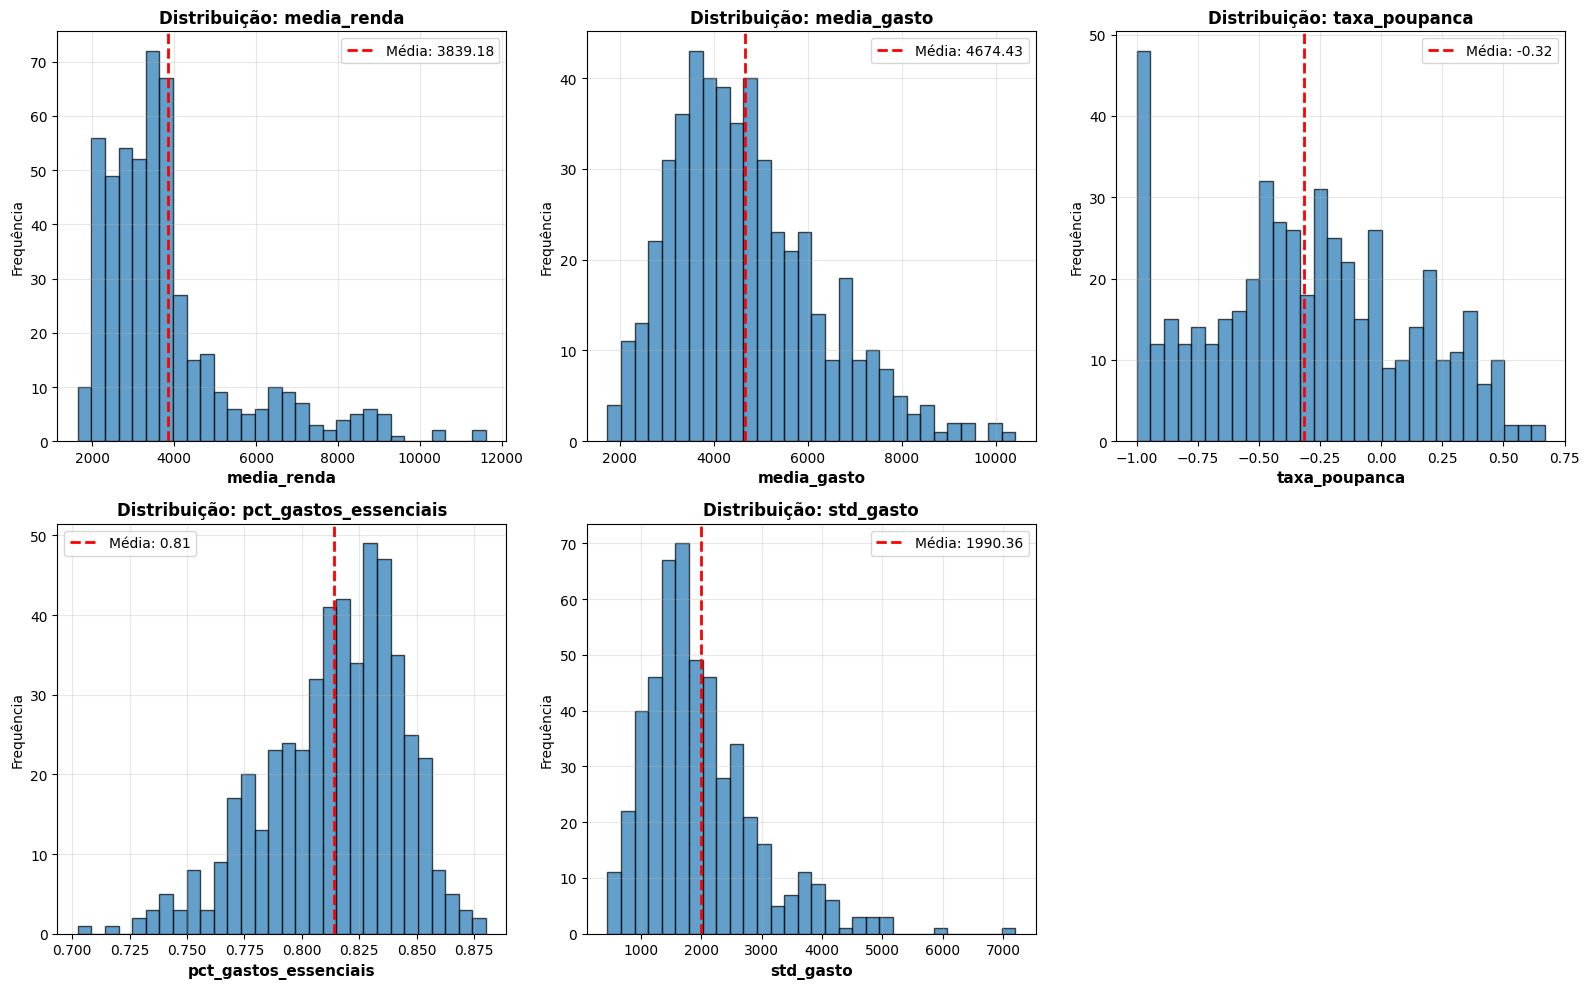

In [12]:
# Visualizar distribuições
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.ravel()

features_to_plot = ['media_renda', 'media_gasto', 'taxa_poupanca', 
                    'pct_gastos_essenciais', 'std_gasto']

for i, feature in enumerate(features_to_plot):
    axes[i].hist(df_features[feature], bins=30, edgecolor='black', alpha=0.7)
    axes[i].set_xlabel(feature, fontsize=11, fontweight='bold')
    axes[i].set_ylabel('Frequência', fontsize=10)
    axes[i].set_title(f'Distribuição: {feature}', fontsize=12, fontweight='bold')
    axes[i].axvline(df_features[feature].mean(), color='red', linestyle='--', 
                    linewidth=2, label=f'Média: {df_features[feature].mean():.2f}')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

# Remover subplot vazio
fig.delaxes(axes[5])

plt.tight_layout()
plt.show()

## 7. Matriz de Correlação

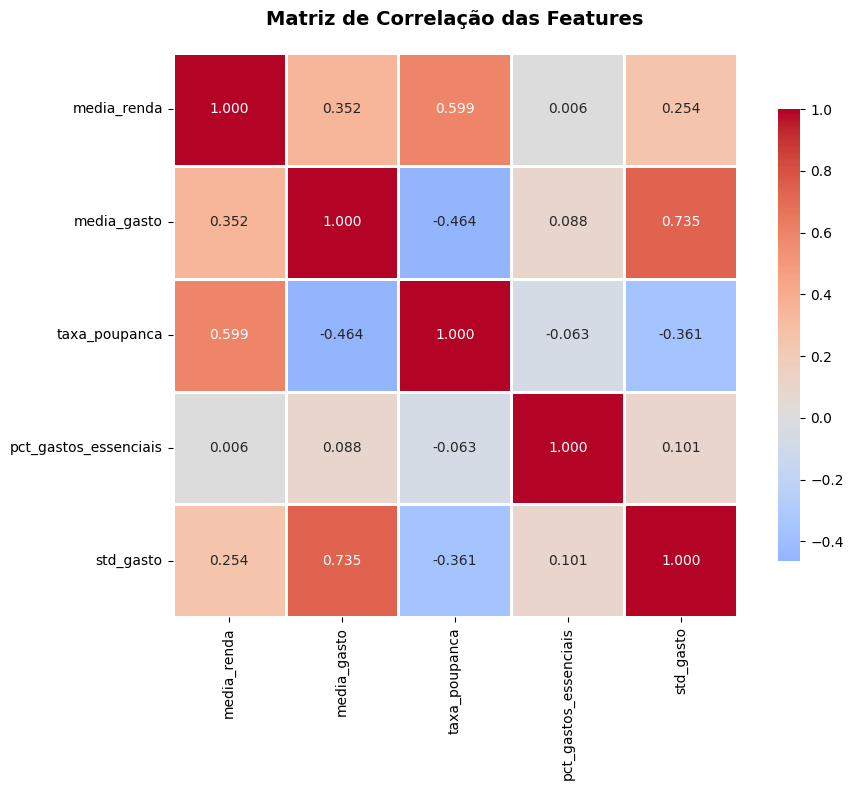


Correlações mais fortes:
   - media_gasto <-> std_gasto: 0.735
   - media_renda <-> taxa_poupanca: 0.599
   - media_gasto <-> taxa_poupanca: -0.464
   - taxa_poupanca <-> std_gasto: -0.361
   - media_renda <-> media_gasto: 0.352


In [13]:
# Calcular correlações
correlation_matrix = df_features[features_to_plot].corr()

# Visualizar heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.3f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Matriz de Correlação das Features', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("\nCorrelações mais fortes:")
corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_pairs.append((
            correlation_matrix.columns[i],
            correlation_matrix.columns[j],
            correlation_matrix.iloc[i, j]
        ))

corr_pairs_sorted = sorted(corr_pairs, key=lambda x: abs(x[2]), reverse=True)

for feat1, feat2, corr in corr_pairs_sorted[:5]:
    print(f"   - {feat1} <-> {feat2}: {corr:.3f}")

## 8. Verificações Finais

In [14]:
print("=" * 80)
print("VERIFICACOES FINAIS")
print("=" * 80)

# Checklist de validacao
checks = {
    "Total de usuarios = 500": len(df_features) == 500,
    "Total de colunas = 6 (user_id + 5 features)": len(df_features.columns) == 6,
    "Sem valores nulos": df_features.isnull().sum().sum() == 0,
    "Sem duplicatas de user_id": df_features['user_id'].nunique() == len(df_features),
    "taxa_poupanca entre -1 e 1": (df_features['taxa_poupanca'].min() >= -1) and (df_features['taxa_poupanca'].max() <= 1),
    "pct_gastos_essenciais entre 0 e 1": (df_features['pct_gastos_essenciais'].min() >= 0) and (df_features['pct_gastos_essenciais'].max() <= 1),
    "Todas features numericas (5 colunas)": df_features.select_dtypes(include=[np.number]).shape[1] == 5
}

print("\nChecklist de Validacao:\n")
all_passed = True
for check, passed in checks.items():
    status = "OK" if passed else "FALHOU"
    print(f"   [{status}] {check}")
    if not passed:
        all_passed = False

if all_passed:
    print("\n" + "=" * 80)
    print("Todas as validacoes passaram. Dataset pronto para clustering.")
    print("=" * 80)
else:
    print("\nAtencao: Algumas validacoes falharam. Verifique os dados.")

VERIFICACOES FINAIS

Checklist de Validacao:

   [OK] Total de usuarios = 500
   [OK] Total de colunas = 6 (user_id + 5 features)
   [OK] Sem valores nulos
   [OK] Sem duplicatas de user_id
   [OK] taxa_poupanca entre -1 e 1
   [OK] pct_gastos_essenciais entre 0 e 1
   [OK] Todas features numericas (5 colunas)

Todas as validacoes passaram. Dataset pronto para clustering.


## 9. Salvar Dataset de Features

In [15]:
# Salvar CSV
output_path = '../data/processed/features_clustering.csv'

# Criar diretório se não existir
import os
os.makedirs('../data/processed', exist_ok=True)

# Salvar
df_features.to_csv(output_path, index=False)

print("=" * 80)
print("ARQUIVO SALVO COM SUCESSO")
print("=" * 80)
print(f"\nArquivo: {output_path}")
print(f"Shape: {df_features.shape}")
print(f"Tamanho: {os.path.getsize(output_path) / 1024:.2f} KB")

print("\nEntregável do Dia 3 concluído.")
print("\nPróximos passos:")
print("   → Treinar K-means (K=3,4,5)")
print("   → Validar clustering (Silhouette > 0.5)")

ARQUIVO SALVO COM SUCESSO

Arquivo: ../data/processed/features_clustering.csv
Shape: (500, 6)
Tamanho: 47.95 KB

Entregável do Dia 3 concluído.

Próximos passos:
   → Treinar K-means (K=3,4,5)
   → Validar clustering (Silhouette > 0.5)


## 10. Resumo Executivo

In [16]:
print("=" * 80)
print("RESUMO EXECUTIVO - FEATURE ENGINEERING")
print("=" * 80)

print("\nDATASET CRIADO:")
print(f"   • Arquivo: features_clustering.csv")
print(f"   • Dimensões: {df_features.shape[0]} usuários × {df_features.shape[1]-1} features")
print(f"   • Qualidade: 0 valores nulos, 0 duplicatas")

print("\nFEATURES CRIADAS:")
for i, feature in enumerate(features_to_plot, 1):
    mean_val = df_features[feature].mean()
    std_val = df_features[feature].std()
    print(f"   {i}. {feature}: μ={mean_val:.3f}, σ={std_val:.3f}")

print("\nINSIGHTS PRINCIPAIS:")
print(f"   • Renda média: R${df_features['media_renda'].mean():.2f}")
print(f"   • Gasto médio: R${df_features['media_gasto'].mean():.2f}")
print(f"   • Taxa de poupança média: {df_features['taxa_poupanca'].mean()*100:.1f}%")
print(f"   • Gastos essenciais médios: {df_features['pct_gastos_essenciais'].mean()*100:.1f}%")
print(f"   • Variabilidade média: R${df_features['std_gasto'].mean():.2f}")

print("\nPRÓXIMAS ETAPAS:")
print("   1. Normalizar features com StandardScaler")
print("   2. Aplicar K-means para K=3,4,5")
print("   3. Calcular métricas: Silhouette, Davies-Bouldin")
print("   4. Meta: Silhouette > 0.5")

print("\n" + "=" * 80)
print("DIA 3 - FEATURE ENGINEERING CONCLUÍDO.")
print("=" * 80)

RESUMO EXECUTIVO - FEATURE ENGINEERING

DATASET CRIADO:
   • Arquivo: features_clustering.csv
   • Dimensões: 500 usuários × 5 features
   • Qualidade: 0 valores nulos, 0 duplicatas

FEATURES CRIADAS:
   1. media_renda: μ=3839.178, σ=1728.309
   2. media_gasto: μ=4674.432, σ=1566.111
   3. taxa_poupanca: μ=-0.316, σ=0.421
   4. pct_gastos_essenciais: μ=0.814, σ=0.030
   5. std_gasto: μ=1990.362, σ=928.327

INSIGHTS PRINCIPAIS:
   • Renda média: R$3839.18
   • Gasto médio: R$4674.43
   • Taxa de poupança média: -31.6%
   • Gastos essenciais médios: 81.4%
   • Variabilidade média: R$1990.36

PRÓXIMAS ETAPAS:
   1. Normalizar features com StandardScaler
   2. Aplicar K-means para K=3,4,5
   3. Calcular métricas: Silhouette, Davies-Bouldin
   4. Meta: Silhouette > 0.5

DIA 3 - FEATURE ENGINEERING CONCLUÍDO.


---

## Notas Finais

**O que foi feito:**
- Criadas 5 features essenciais
- Dataset validado (500 × 5)
- Arquivo `features_clustering.csv` salvo
- Estatísticas e visualizações geradas
- Correlações analisadas

**Features criadas:**
1. **media_renda:** Capacidade financeira
2. **media_gasto:** Nível de consumo
3. **taxa_poupanca:** Comportamento de poupança
4. **pct_gastos_essenciais:** Prioridades de gasto
5. **std_gasto:** Estabilidade financeira

**Próximo notebook:** `03_Clustering.ipynb` (Sprint 1, Dias 4-5)

---

**Tempo estimado:** 1h30  
**Status:** Concluído  
**Data:** [Preencher com a data de execução]

**Entregável:** `data/processed/features_clustering.csv` (500 usuários × 5 features)